# Assignment-2

### Name : P. V. Sriram
### Roll No.: 1801CS37

# Question

Download the dataset provided in this [webpage](https://www.analyticsvidhya.com/blog/2019/10/how-to-build-knowledge-graph-text-using-spacy/). Follow the instructions in the page and create a knowledge graph. Identify the important personalities and locations based on PageRank and Betweenness centrality.

# Setup

In [1]:
import re
import pandas as pd
import bs4
import requests
import spacy
from spacy import displacy
nlp = spacy.load('en_core_web_sm')

from spacy.matcher import Matcher 
from spacy.tokens import Span 

import networkx as nx
from networkx.algorithms.link_analysis.pagerank_alg import pagerank
from networkx.algorithms.centrality import betweenness_centrality

import matplotlib.pyplot as plt
from tqdm import tqdm

pd.set_option('display.max_colwidth', 200)
%matplotlib inline

In [2]:
# import wikipedia sentences
candidate_sentences = pd.read_csv("wiki_sentences_v2.csv")
candidate_sentences.shape

(4318, 1)

# Extract Entities (Subject & Object)

In [3]:
def get_entities(sent):
    
    # Finding named entities in sent
    doc = nlp(sent)
    entity_names = [ent.text for ent in doc.ents]
    entity_labels = [ent.label_ for ent in doc.ents]
    ## chunk 1
    ent1 = ""
    ent2 = ""

    prv_tok_dep = ""    # dependency tag of previous token in the sentence
    prv_tok_text = ""   # previous token in the sentence

    prefix = ""
    modifier = ""

    #############################################################

    for tok in nlp(sent):
        ## chunk 2
        # if token is a punctuation mark then move on to the next token
        if tok.dep_ != "punct":
            # check: token is a compound word or not
            if tok.dep_ == "compound":
                prefix = tok.text
                # if the previous word was also a 'compound' then add the current word to it
                if prv_tok_dep == "compound":
                    prefix = prv_tok_text + " "+ tok.text

        # check: token is a modifier or not
        if tok.dep_.endswith("mod") == True:
            modifier = tok.text
            # if the previous word was also a 'compound' then add the current word to it
            if prv_tok_dep == "compound":
                modifier = prv_tok_text + " "+ tok.text

        ## chunk 3
        if tok.dep_.find("subj") == True:
            ent1 = modifier +" "+ prefix + " "+ tok.text
            prefix = ""
            modifier = ""
            prv_tok_dep = ""
            prv_tok_text = ""      

        ## chunk 4
        if tok.dep_.find("obj") == True:
            ent2 = modifier +" "+ prefix +" "+ tok.text

        ## chunk 5  
        # update variables
        prv_tok_dep = tok.dep_
        prv_tok_text = tok.text
        
    #############################################################
    for element in ent1.split(" "):
        entity_type_1 = 'None'
        if element in entity_names:
            index = entity_names.index(element)
            ent_label = entity_labels[index]
            if ent_label == 'NORP':
                entity_type_1 = 'Personality'
            elif ent_label == 'GPE':
                entity_type_1 = 'Location'

    for element in ent2.split(" "):
        entity_type_2 = 'None'
        if element in entity_names:
            index = entity_names.index(element)
            ent_label = entity_labels[index]
            if ent_label == 'NORP' or ent_label == 'ORG':
                entity_type_2 = 'Personality'
            elif ent_label == 'GPE':
                entity_type_2 = 'Location'
                
    return ((ent1.strip(), entity_type_1), (ent2.strip(), entity_type_2))

In [4]:
# Extract entity pairs from each sentence
entity_pairs = []
entity_types = {}

for i in tqdm(candidate_sentences["sentence"]):
    entity_1, entity_2 = get_entities(i)
    entity_pairs.append([entity_1[0], entity_2[0]])
    entity_types[entity_1[0]] = entity_1[1]
    entity_types[entity_2[0]] = entity_2[1]

100%|██████████████████████████████████████| 4318/4318 [00:40<00:00, 105.88it/s]


# Extract Relations (Verbs)

In [5]:
def get_relation(sent):

    doc = nlp(sent)

    # Matcher class object 
    matcher = Matcher(nlp.vocab)

    #define the pattern 
    pattern = [{'DEP':'ROOT'}, 
            {'DEP':'prep','OP':"?"},
            {'DEP':'agent','OP':"?"},  
            {'POS':'ADJ','OP':"?"}] 

    matcher.add("matching_1", [pattern], on_match=None) 

    matches = matcher(doc)
    k = len(matches) - 1

    span = doc[matches[k][1]:matches[k][2]] 

    return(span.text)

In [6]:
# Extract relations from each sentence
relations = [get_relation(i) for i in tqdm(candidate_sentences['sentence'])]

100%|██████████████████████████████████████| 4318/4318 [00:20<00:00, 209.31it/s]


In [7]:
# extract subject
source = [i[0] for i in entity_pairs]

# extract object
target = [i[1] for i in entity_pairs]

kg_df = pd.DataFrame({'source':source, 'target':target, 'edge':relations, 
                      'source_type':[entity_types[x] for x in source], 
                      'target_type':[entity_types[x] for x in target]})

# Plot Knowledge Graph

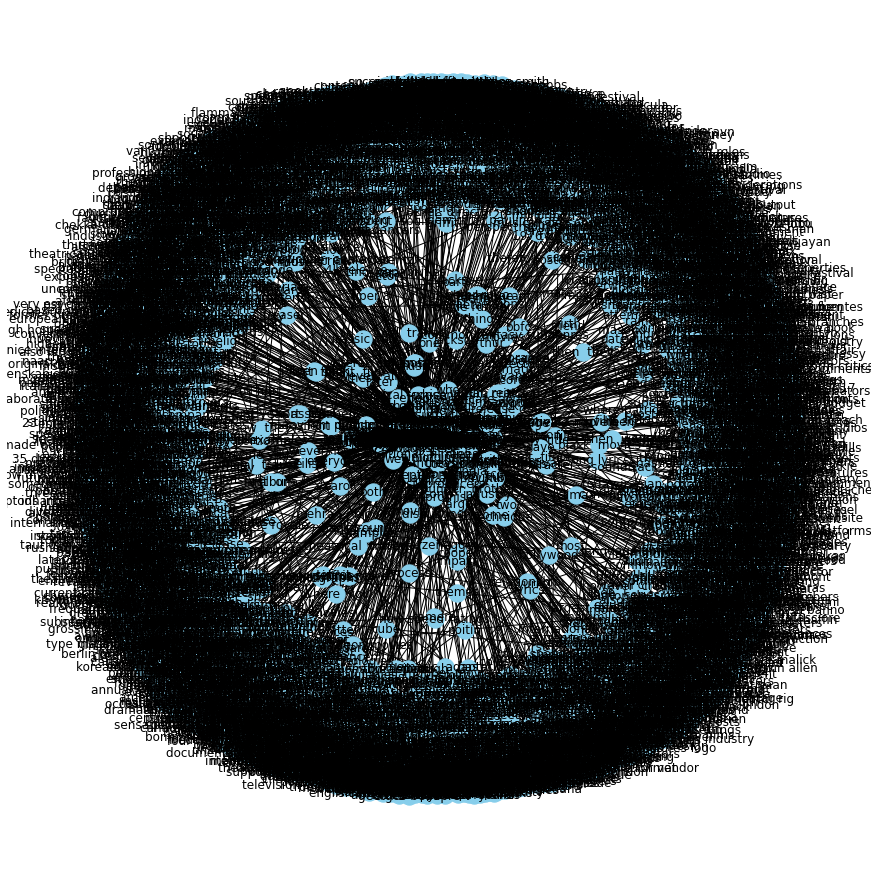

In [8]:
# create a directed-graph from a dataframe
G=nx.from_pandas_edgelist(kg_df, "source", "target", 
                          edge_attr=True, create_using=nx.DiGraph())
nx.set_node_attributes(G, values = entity_types, name='type')

plt.figure(figsize=(12,12))

pos = nx.spring_layout(G)
nx.draw(G, with_labels=True, node_color='skyblue', edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

In [9]:
# Betweenness Centrality
bn = betweenness_centrality(G)
bn = sorted(bn.items(), key=lambda item: item[1], reverse = True)

In [10]:
# Top entities considering all kinds of nodes
print("Top 10 entites based on Betweenness centrality:")
bn[:10]

Top 10 entites based on Betweenness centrality:


[('film', 0.001440642260991783),
 ('', 0.0013697462228097347),
 ('it', 0.0005731280424664372),
 ('this', 0.0003816507974873087),
 ('that', 0.00028048012303545964),
 ('music', 0.0001271824432769614),
 ('eilis', 0.00010396430117530981),
 ('films', 0.00010019807848145902),
 ('sequel', 7.718687169265637e-05),
 ('soundtrack', 7.577971156528355e-05)]

In [11]:
# Pagerank Centrality
pr = pagerank(G)
pr = sorted(pr.items(), key=lambda item: item[1], reverse = True)

In [12]:
# Top entities considering all kinds of nodes
print("Top 10 entites based on Page Rank centrality:")
pr[:10]

Top 10 entites based on Page Rank centrality:


[('', 0.006427768843810376),
 ('film', 0.0036383935101247703),
 ('him', 0.0017784284109153136),
 ('it', 0.001740290585411589),
 ('that', 0.0012468549227105698),
 ('december', 0.0011080809791448347),
 ('time', 0.0010417619936354497),
 ('april', 0.0010308549358775672),
 ('them', 0.0010217986208158698),
 ('november', 0.0009868703651856783)]

# Plotting Sub Graphs

## Personality Entites

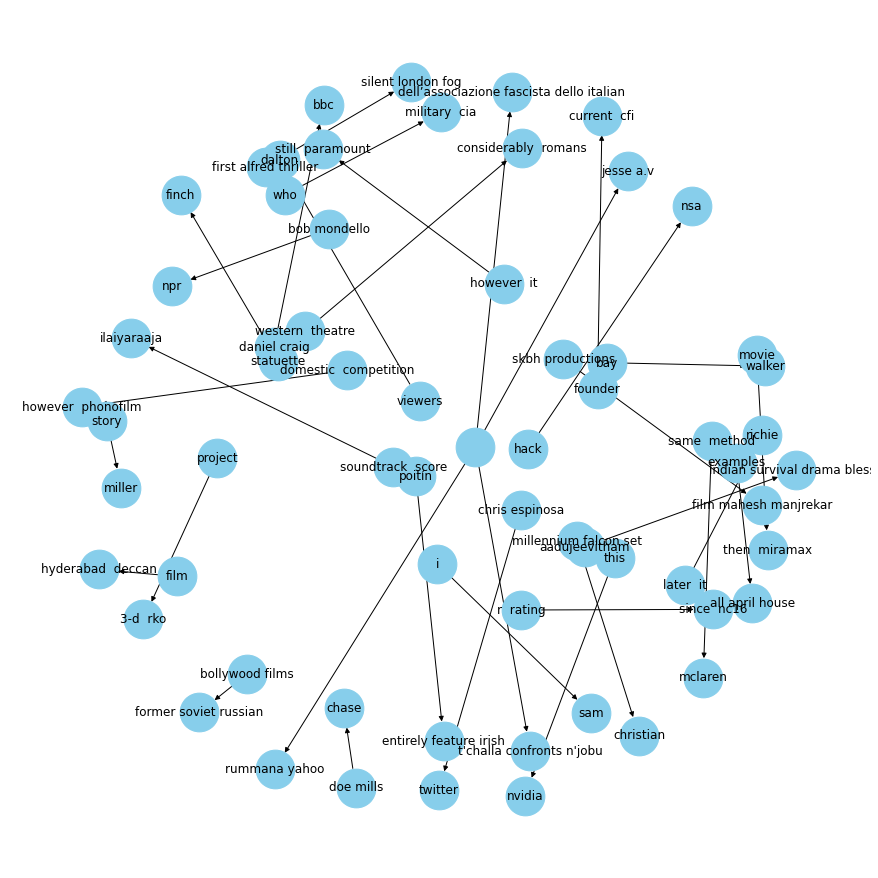

In [13]:
# Plotting relations with target "Personality" Entites only
G=nx.from_pandas_edgelist(kg_df[kg_df['target_type']=="Personality"], "source", "target", 
                          edge_attr=True, create_using=nx.DiGraph())

plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, k = 0.5) # k regulates the distance between nodes
nx.draw(G, with_labels=True, node_color='skyblue', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

In [14]:
# Betweenness Centrality
bn = betweenness_centrality(G)
bn = sorted(bn.items(), key=lambda item: item[1], reverse = True)

In [15]:
# Top entities
print("Top 10 entites based on Betweenness centrality:")
bn[:10]

Top 10 entites based on Betweenness centrality:


[('examples', 0.0),
 ('all april house', 0.0),
 ('first alfred thriller', 0.0),
 ('silent london fog', 0.0),
 ('same  method', 0.0),
 ('mclaren', 0.0),
 ('story', 0.0),
 ('miller', 0.0),
 ('western  theatre', 0.0),
 ('considerably  romans', 0.0)]

In [16]:
# Pagerank Centrality
pr = pagerank(G)
pr = sorted(pr.items(), key=lambda item: item[1], reverse = True)

In [17]:
# Top entities
print("Top 10 entites based on Page Rank centrality:")
pr[:10]

Top 10 entites based on Page Rank centrality:


[('all april house', 0.020252015364126713),
 ('silent london fog', 0.020252015364126713),
 ('mclaren', 0.020252015364126713),
 ('miller', 0.020252015364126713),
 ('considerably  romans', 0.020252015364126713),
 ('film mahesh manjrekar', 0.020252015364126713),
 ('ilaiyaraaja', 0.020252015364126713),
 ('indian survival drama blessy', 0.020252015364126713),
 ('3-d  rko', 0.020252015364126713),
 ('nvidia', 0.020252015364126713)]

## Location Entities

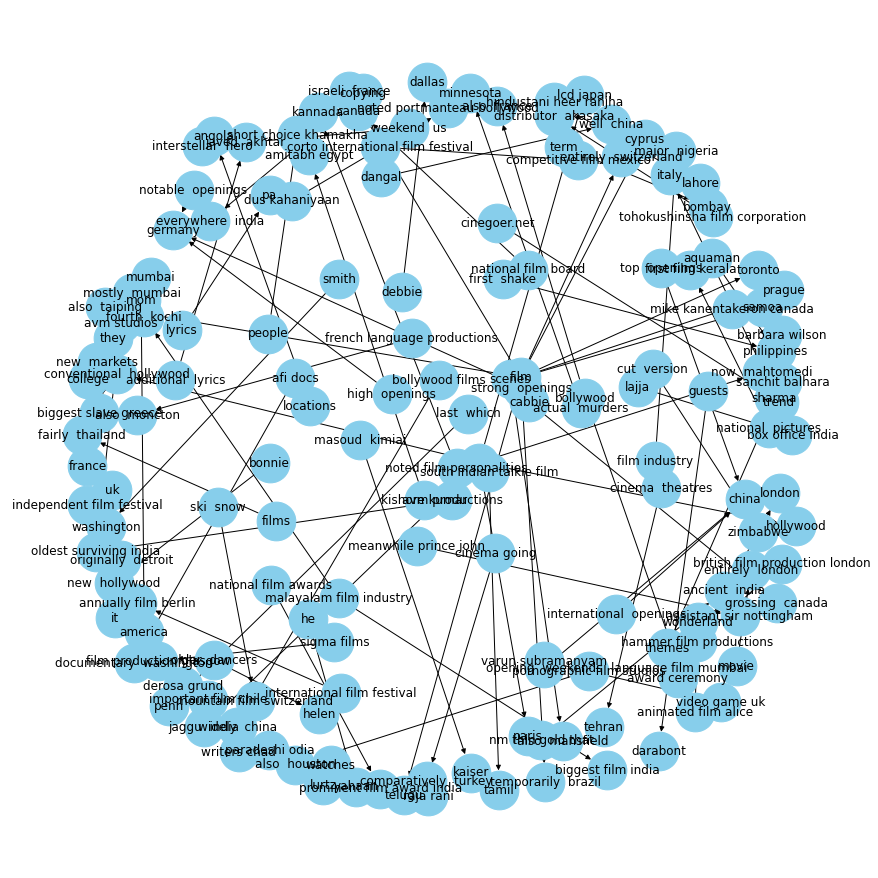

In [18]:
# Plotting relations with target "Location" Entites only

G=nx.from_pandas_edgelist(kg_df[kg_df['target_type']=="Location"], "source", "target", 
                          edge_attr=True, create_using=nx.DiGraph())

plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, k = 0.5)
nx.draw(G, with_labels=True, node_color='skyblue', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

In [19]:
# Betweenness Centrality
bn = betweenness_centrality(G)
bn = sorted(bn.items(), key=lambda item: item[1], reverse = True)

In [20]:
# Top entities
print("Top 10 entites based on Betweenness centrality:")
bn[:10]

Top 10 entites based on Betweenness centrality:


[('last  which', 0.0),
 ('penn', 0.0),
 ('', 0.0),
 ('paris', 0.0),
 ('national film awards', 0.0),
 ('prominent film award india', 0.0),
 ('new  markets', 0.0),
 ('france', 0.0),
 ('first  shake', 0.0),
 ('philippines', 0.0)]

In [21]:
# Pagerank Centrality
pr = pagerank(G)
pr = sorted(pr.items(), key=lambda item: item[1], reverse = True)

In [22]:
# Top entities
print("Top 10 entites based on Page Rank centrality:")
pr[:10]

Top 10 entites based on Page Rank centrality:


[('china', 0.015596634939584221),
 ('germany', 0.015596634939584221),
 ('philippines', 0.011862369818150255),
 ('oldest surviving india', 0.011862369818150255),
 ('washington', 0.009372859737194277),
 ('penn', 0.00812810469671629),
 ('prominent film award india', 0.00812810469671629),
 ('france', 0.00812810469671629),
 ('video game uk', 0.00812810469671629),
 ('uk', 0.00812810469671629)]